In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             make_scorer)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     KFold,
                                     StratifiedKFold,
                                     learning_curve,
                                     validation_curve,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.feature_selection import (SelectKBest,
                                       f_classif,
                                       f_regression,
                                       chi2,
                                       RFECV,
                                       VarianceThreshold)

import utils

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/parole.csv', low_memory=False)
data.head()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0


In [4]:
# Convert to numpy
X, y = data.values[:, :-1], data.values[:, -1].astype('int')
print(f'Shape : {X.shape}, {y.shape}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
print(f'Training : {X_train.shape}')
print(f'Test : {X_test.shape}')

Shape : (675, 8), (675,)
Training : (472, 8)
Test : (203, 8)


In [5]:
# Create CV objest
kf = StratifiedKFold(5, shuffle=True, random_state=1)

In [8]:
rf_clf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(100, class_weight='balanced'))
cv_auc = cross_val_score(rf_clf, X_train, y_train,
                         scoring='roc_auc', n_jobs=-1, cv=kf)
print(f'10-fold cv AUC : {cv_auc.mean():.2f}')

10-fold cv AUC : 0.83


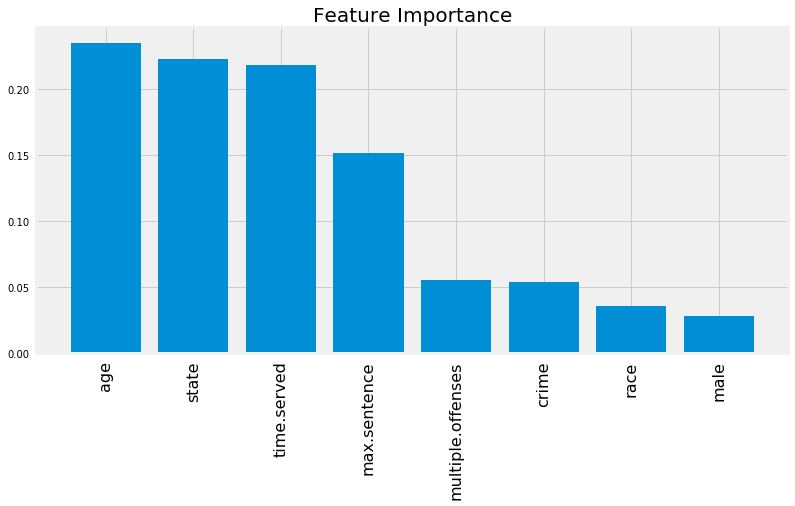

In [10]:
rf_clf.fit(X_train, y_train)
utils.plot_feature_imp(rf_clf.named_steps['randomforestclassifier'], data.columns[:-1])

In [14]:
fvalue_selector = SelectKBest(f_classif, k=2)
fvalue_selector.fit_transform(X_train, y_train)

array([[ 4., 13.],
       [ 4., 13.],
       [ 2., 18.],
       [ 4., 12.],
       [ 4., 13.],
       [ 4., 12.],
       [ 3., 12.],
       [ 4., 12.],
       [ 4., 15.],
       [ 4., 12.],
       [ 1., 12.],
       [ 1., 12.],
       [ 2., 12.],
       [ 1., 13.],
       [ 4., 14.],
       [ 4., 15.],
       [ 4., 13.],
       [ 1., 18.],
       [ 1., 12.],
       [ 4., 13.],
       [ 3.,  2.],
       [ 2., 12.],
       [ 4., 16.],
       [ 1., 12.],
       [ 1., 12.],
       [ 4., 15.],
       [ 4., 13.],
       [ 4., 12.],
       [ 4., 16.],
       [ 3.,  4.],
       [ 2., 12.],
       [ 2., 12.],
       [ 3.,  2.],
       [ 1., 12.],
       [ 3., 18.],
       [ 4., 12.],
       [ 1.,  8.],
       [ 4., 12.],
       [ 1., 18.],
       [ 2., 12.],
       [ 4., 12.],
       [ 2., 12.],
       [ 1., 12.],
       [ 4., 13.],
       [ 1., 18.],
       [ 3., 12.],
       [ 4., 15.],
       [ 2., 12.],
       [ 1., 18.],
       [ 4., 15.],
       [ 4., 18.],
       [ 2., 12.],
       [ 4.,

In [19]:
data.columns[:-1][fvalue_selector.get_support()]

Index(['state', 'max.sentence'], dtype='object')

In [21]:
chi2_selector = SelectKBest(chi2, k=2)
chi2_selector.fit_transform(X_train, y_train)
data.columns[:-1][chi2_selector.get_support()]

Index(['state', 'max.sentence'], dtype='object')

In [29]:
df = pd.DataFrame(X_train)
corr_matrix = df.corr().abs()
corr_matrix

,0,1,2,3,4,5,6,7
0,1.000000,0.022632,0.024479,0.019760,0.039626,0.003292,0.047604,0.003918
1,0.022632,1.000000,0.025960,0.445468,0.094934,0.003363,0.231746,0.153883
2,0.024479,0.025960,1.000000,0.074408,0.009665,0.020807,0.063759,0.085749
3,0.019760,0.445468,0.074408,1.000000,0.129469,0.115078,0.509189,0.165576
4,0.039626,0.094934,0.009665,0.129469,1.000000,0.157042,0.176658,0.004800
5,0.003292,0.003363,0.020807,0.115078,0.157042,1.000000,0.005462,0.060279
6,0.047604,0.231746,0.063759,0.509189,0.176658,0.005462,1.000000,0.136628
7,0.003918,0.153883,0.085749,0.165576,0.004800,0.060279,0.136628,1.000000


In [36]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,0,1,2,3,4,5,6,7
0,NaN,0.022632,0.024479,0.019760,0.039626,0.003292,0.047604,0.003918
1,NaN,NaN,0.025960,0.445468,0.094934,0.003363,0.231746,0.153883
2,NaN,NaN,NaN,0.074408,0.009665,0.020807,0.063759,0.085749
3,NaN,NaN,NaN,NaN,0.129469,0.115078,0.509189,0.165576
4,NaN,NaN,NaN,NaN,NaN,0.157042,0.176658,0.004800
5,NaN,NaN,NaN,NaN,NaN,NaN,0.005462,0.060279
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136628
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
[col for col in upper.columns if any(upper[col] > 0.95)]

[]

Feature Selection:
- Correlation
- Variance
- PCA
- LASSOCV()
- f_classify
- f_regression
- chi2
- RFECV

In [27]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                random_state=1)
sfs1 = sfs(estimator=rf_clf,
           k_features=1,
           forward=True,
           scoring='accuracy',
           cv=kf,
           n_jobs=-1)

pipe = Pipeline([('std', StandardScaler()),
                 ('sfs', sfs1),
                 ('clf', rf_clf)])

param_grid = {'sfs__k_features': list(range(1, 9))}

gs = GridSearchCV(pipe,
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1,
                  cv=kf)

In [28]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfs', SequentialFeatureSelector(clone_estimator=True,
             cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gin...stimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'sfs__k_features': [1, 2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
gs.best_score_

0.8961864406779662

In [30]:
gs.best_params_

{'sfs__k_features': 5}

In [32]:
gs.cv_results_['mean_test_score']

array([0.88347458, 0.88347458, 0.87711864, 0.88983051, 0.89618644,
       0.87923729, 0.87923729, 0.88347458])

(0.8, 0.9)

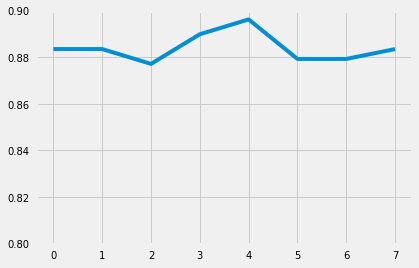

In [35]:
plt.plot(gs.cv_results_['mean_test_score'])
plt.ylim([0.8, 0.9])